## 라이브러리 호출

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import os

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

### 데이터 호출
이때 노드에서 학습한 `os`모듈을 사용하여 경로 저장후, 데이터 호출

In [50]:
path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
train_path = os.path.join(path + '/train.csv')
test_path = os.path.join(path + '/test.csv')

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print("train shape :",df_train.shape)
print("test shape",df_test.shape)

train shape : (15035, 21)
test shape (6468, 20)


## 변수 설명

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : Has been viewed
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [14]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

null값은 존재하지 않고, 텍스트 데이터또한 존재하지 않음

## 타겟 변수의 시각화 및 통계적 분석

<AxesSubplot:xlabel='price', ylabel='Density'>

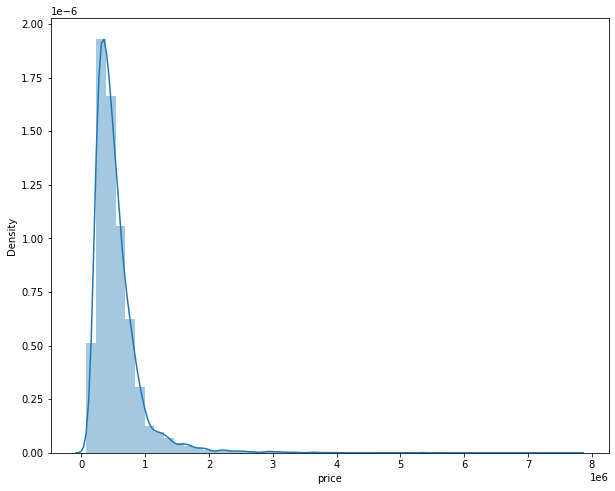

In [17]:
plt.figure(figsize =(10,8))
sns.distplot(df_train['price'])

In [18]:
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


In [19]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

데이터가 정규분포의 형태가 아니며, 분산또한 매우 크기에 이를 normalize를 통해 정규분포 형태로 바꿀 예정

<AxesSubplot:xlabel='price', ylabel='Density'>

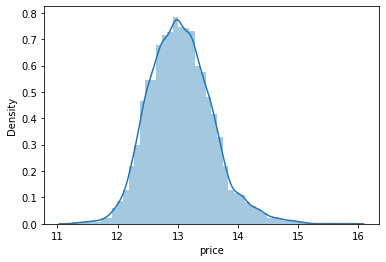

In [51]:
df_train['price'] = np.log1p(df_train['price'])
sns.distplot(df_train['price'])

# EDA

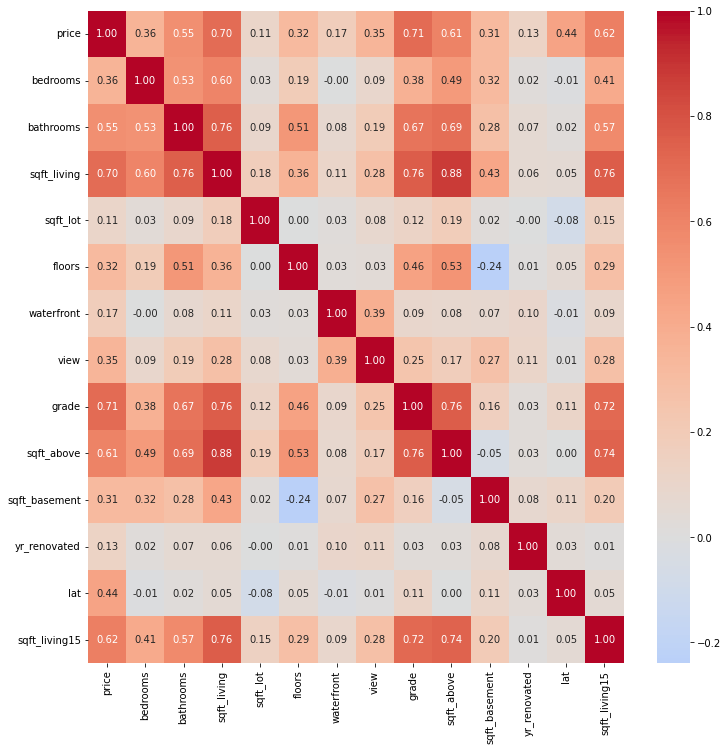

In [52]:
corr = df_train.drop('id',axis =1).corr()


price_correlation = corr['price'].abs()


relevant_columns = price_correlation[price_correlation > 0.1].index


filtered_corr = corr.loc[relevant_columns, relevant_columns]

plt.figure(figsize = (12,12))
sns.heatmap(filtered_corr, fmt='.2f', annot=True, cmap='coolwarm', center=0)
plt.show()

상관관계의 절대값이 0.1이상인 데이터들만 가지고 EDA를 진행할 예정

침실, 화장실, 주거공간의 피트, 부지 피트, 층수, 리버뷰, view, 등급, 지하실 제외 피트, 지하칠 피트, 재건축연도, 위도, 15년 기준 주거공간 피트

In [53]:
relevant_columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'lat', 'sqft_living15'],
      dtype='object')

lat : 데이터셋의주거지는 시애틀, 그래서 시애틀은 북쪽으로 갈수록 살기 좋은 집들이 많다.

상관관계가 높은 데이터들 위주로 해서 데이터 분포를 확인, 이상하면 정규화 할 예정

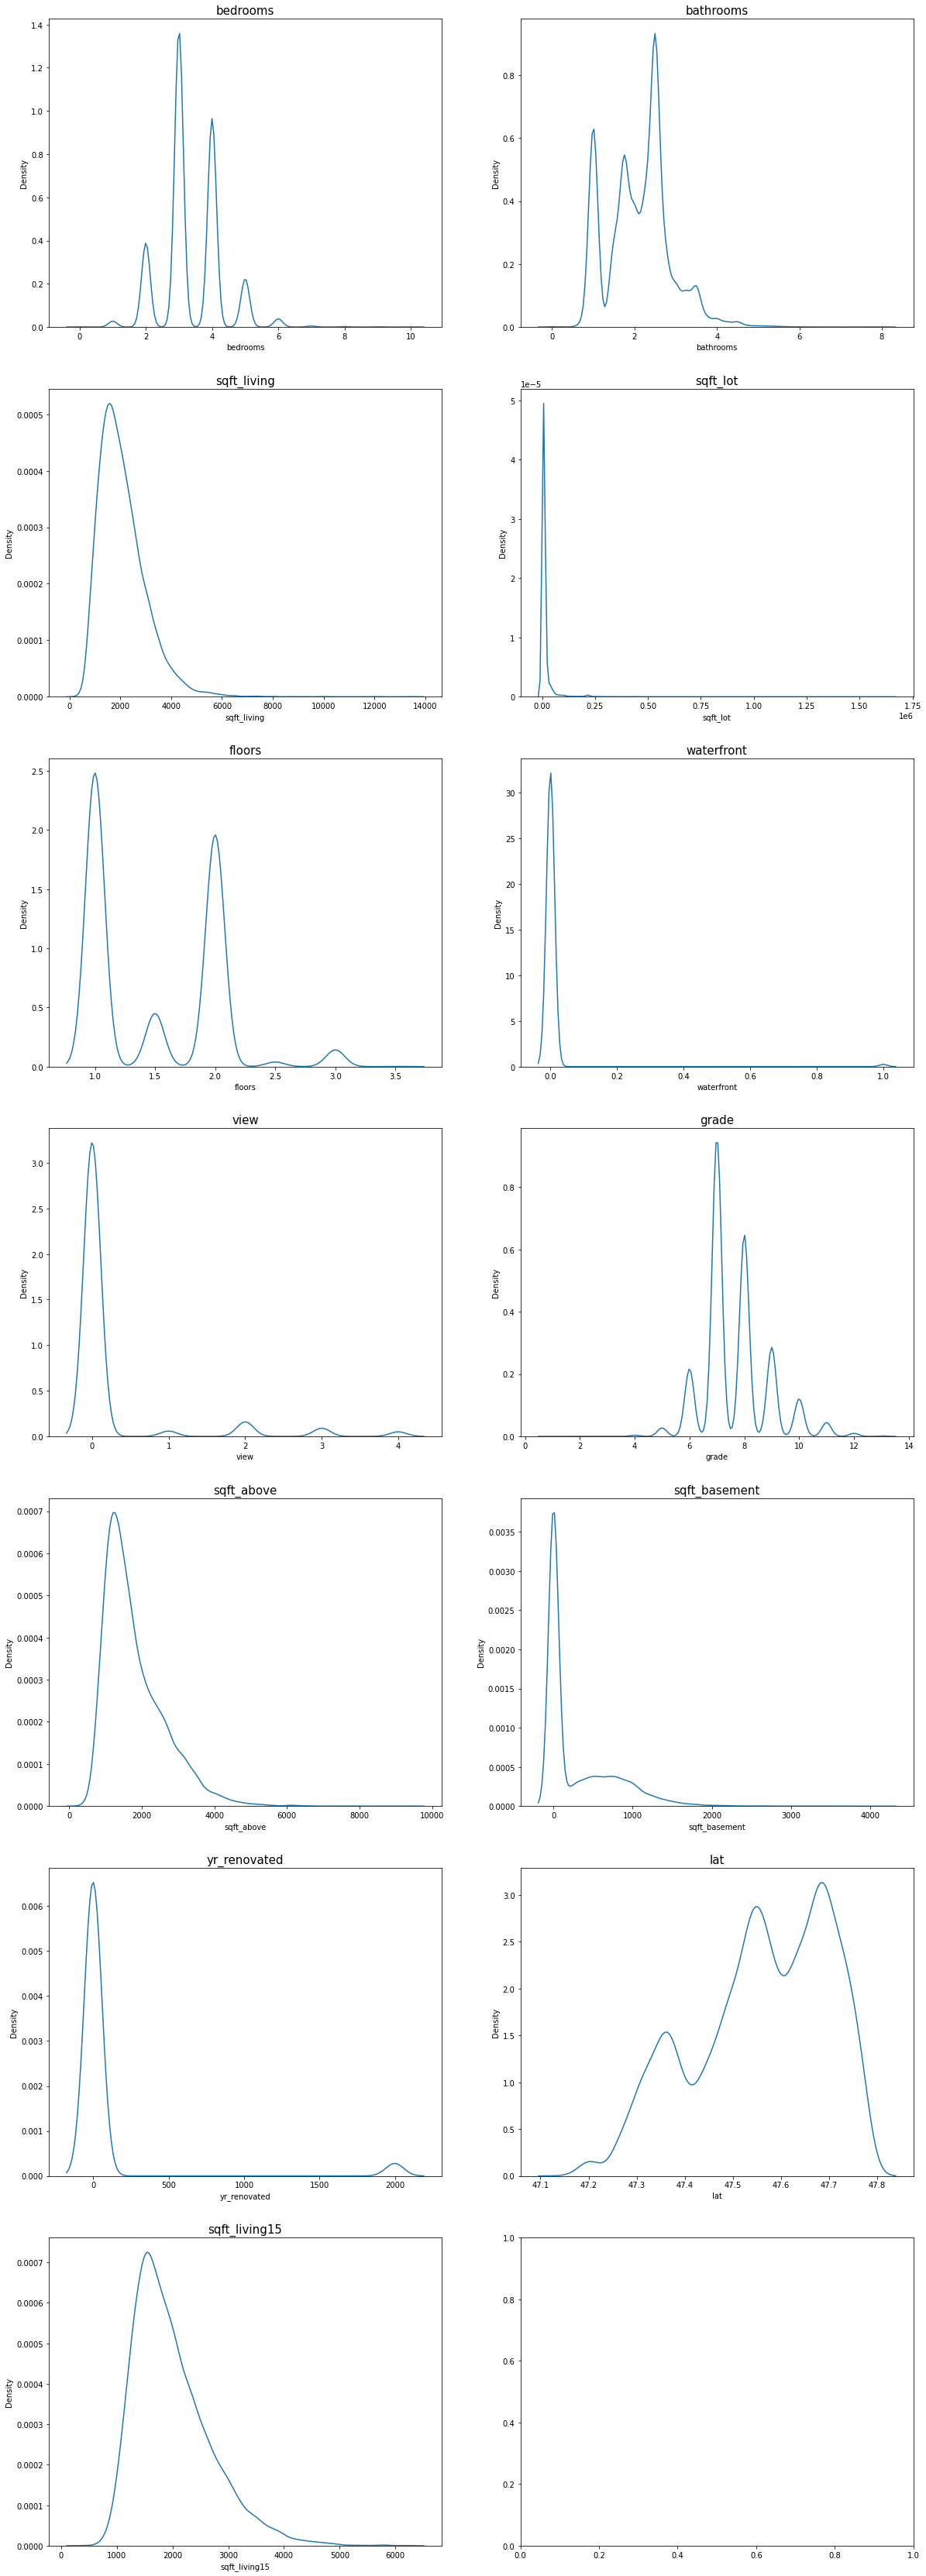

In [54]:
fig, ax = plt.subplots(7, 2, figsize=(20, 60))

count = 1
columns = relevant_columns
for row in range(7):
    for col in range(2):
        sns.kdeplot(df_train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 14 :
            break

In [57]:
# 정규화할 컬럼 목록 (price 제외)
columns_to_log_transform = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                            'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
                            'yr_renovated', 'lat', 'sqft_living15']

# 로그 변환 적용 (0 이하 값 방지를 위해 1을 더함)
df_train[columns_to_log_transform] = df_train[columns_to_log_transform].apply(lambda x: np.log1p(x))

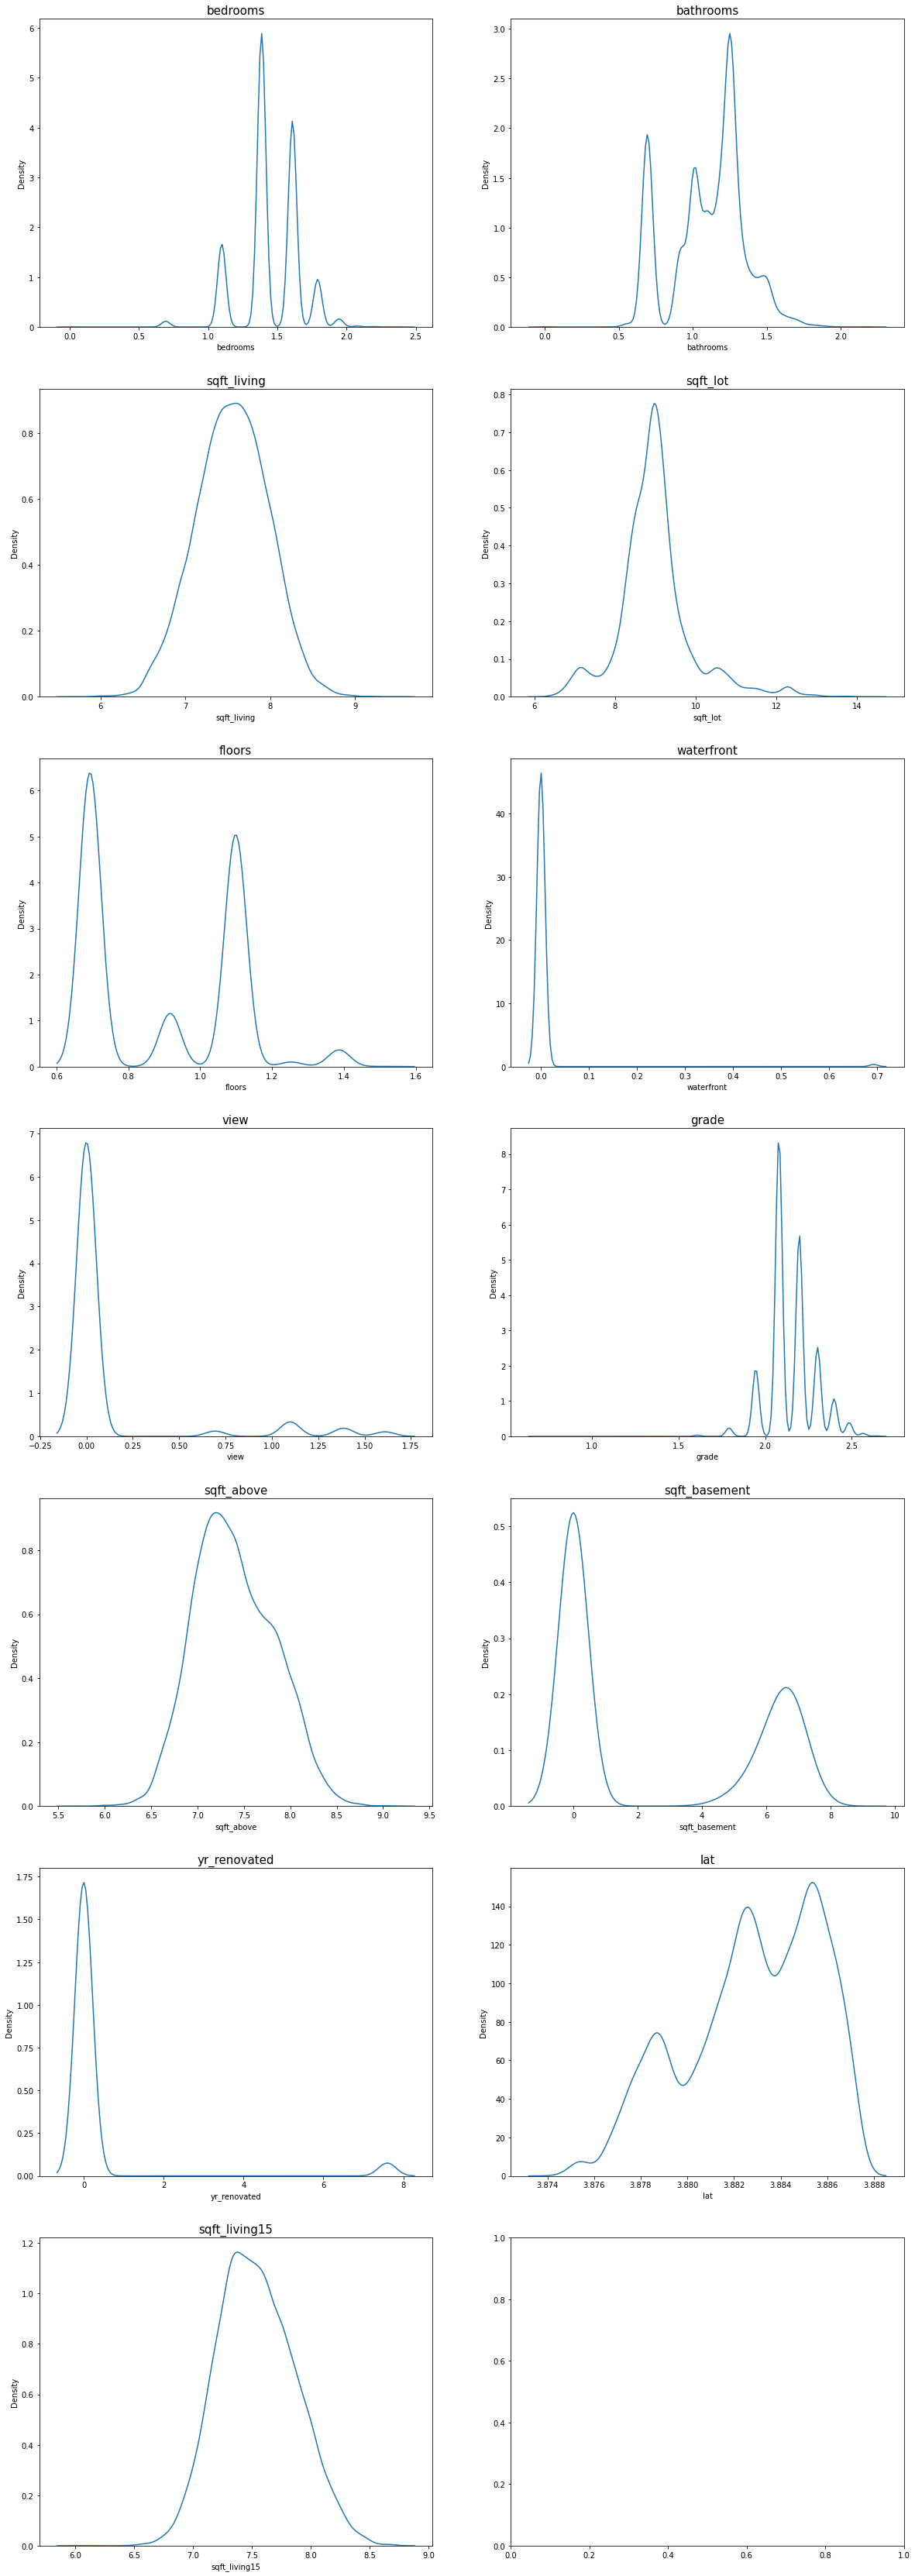

In [58]:
fig, ax = plt.subplots(7, 2, figsize=(20, 60))

count = 1
columns = relevant_columns
for row in range(7):
    for col in range(2):
        sns.kdeplot(df_train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 14 :
            break

In [61]:
df_train=df_train[relevant_columns]

In [62]:
df_train

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15
0,12.309987,1.386294,0.693147,7.074117,8.639588,0.693147,0.0,0.0,2.079442,7.074117,0.000000,0.0,3.881795,7.201171
1,12.100718,1.098612,0.693147,6.647688,9.210440,0.693147,0.0,0.0,1.945910,6.647688,0.000000,0.0,3.886457,7.908755
2,13.142168,1.386294,1.098612,7.427144,8.997271,0.693147,0.0,0.0,2.197225,7.427144,0.000000,0.0,3.883969,7.496097
3,12.458779,1.386294,1.178655,7.447751,8.827615,1.098612,0.0,0.0,2.079442,7.447751,0.000000,0.0,3.877632,7.713785
4,12.583999,1.386294,0.916291,6.966967,9.181118,0.693147,0.0,0.0,2.079442,6.966967,0.000000,0.0,3.879696,7.409136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,13.322338,1.609438,1.252763,7.832411,8.703507,1.098612,0.0,0.0,2.302585,7.832411,0.000000,0.0,3.881846,7.832411
15031,13.822984,1.609438,1.504077,8.163656,8.881975,1.098612,0.0,0.0,2.302585,7.863651,6.814543,0.0,3.882670,7.626083
15032,12.793862,1.386294,1.252763,7.333676,7.031741,1.386294,0.0,0.0,2.197225,7.333676,0.000000,0.0,3.885665,7.333676
15033,12.899222,1.609438,1.252763,7.745436,8.668024,1.098612,0.0,0.0,2.197225,7.745436,0.000000,0.0,3.881784,7.512618


## 하이퍼파라미터 튜닝(검증)

In [63]:
def preprocess_data(df, columns):
    """
    주어진 데이터프레임에서 특정 컬럼에 대해 로그 변환을 적용하는 함수.
    
    Parameters:
    - df: pandas DataFrame, 데이터프레임
    - columns_to_log_transform: list, 로그 변환할 컬럼들의 이름
    
    Returns:
    - df_transformed: pandas DataFrame, 로그 변환이 적용된 데이터프레임
    """
    df_transformed = df.copy()
    df_transformed[columns] = df_transformed[columns].apply(lambda x: np.log1p(x))
    return df_transformed



In [ ]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train['price'] = np.log1p(df_train['price'])

# 사용할 컬럼 목록
columns_to_log_transform = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                            'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
                            'yr_renovated', 'lat', 'sqft_living15']

# 데이터 전처리
df_train_transformed = preprocess_data(df_train, columns_to_log_transform)

# 독립 변수와 종속 변수 분리
X_train = df_train_transformed[columns_to_log_transform]
y_train = df_train_transformed['price']

# 모델과 하이퍼파라미터 그리드 설정
models = {
    'LinearRegression': (LinearRegression(), {}),
    'XGBoost': (XGBRegressor(), {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'booster': ['gbtree', 'gblinear', 'dart']
    }),
    'LightGBM': (LGBMRegressor(), {
       'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'boosting_type': ['gbdt', 'dart']
    })
}

best_models = {}

# 그리드 서치를 통한 하이퍼파라미터 튜닝
for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"{model_name} 최적의 파라미터: {grid_search.best_params_}")
    print(f"{model_name} 최적의 점수: {-grid_search.best_score_}")

LinearRegression 최적의 파라미터: {}
LinearRegression 최적의 점수: 0.07378470367326817
[07:43:04] WARNING: ../src/learner.cc:573: 
Parameters: { "max_depth" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:43:04] WARNING: ../src/learner.cc:573: 
Parameters: { "max_depth" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:43:05] WARNING: ../src/learner.cc:573: 
Parameters: { "max_depth" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

## 학습 결과

In [ ]:

for model_name, model in best_models.items():

    y_pred_log = model.predict(X_test)
    
    # 로그 변환의 역변환 적용
    y_pred = np.expm1(y_pred_log)
    

    submission = pd.DataFrame({
        'Id': df_test['Id'],  
        'Prediction': y_pred
    })
    

    submission.to_csv(f'submission_{model_name}.csv', index=False)
    
    print(f"{model_name} 모델의 예측 결과 파일이 생성되었습니다.")



## 제출결과

## 회고
이번 실습에서는 EDA나, 피처 엔지니어링이 아닌, 하이퍼 파라미터 튜닝을 위주로 실습을 진행을 했다.

상관계수를 기준으로 절대값이 0.1이하인 것들은 제외를 하고 진행을 했는데, 튜닝이 너무 오래걸려서 결과를 시간내에 보지 못한것이 아쉽다.
